# Import Dependencies

In [181]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
import torch.nn.functional as F
from monai.losses import DiceLoss


# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator


# MedSAM
from transformers import SamModel, SamProcessor, SamConfig

from segment_anything import sam_model_registry
from MedSAM.utils.demo import BboxPromptDemo



2.6.0+cu126
True


## Gather data for each split

In [182]:
importlib.reload(image_mask_dataset)
importlib.reload(model_evaluator)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 157/157 [00:00<00:00, 9577.15it/s]


(640, 640, 3)

In [144]:
MedSAM_checkpoint = "Models/medsam_vit_b.pth"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_checkpoint)
medsam_model = medsam_model.to("cuda")
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


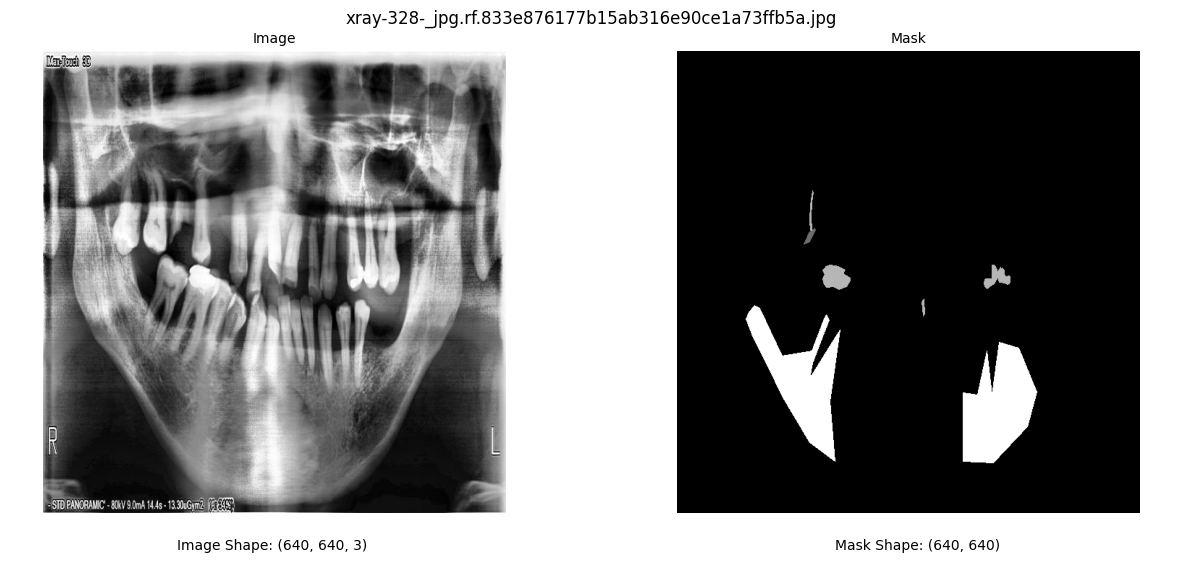

Button(description='clear', style=ButtonStyle())

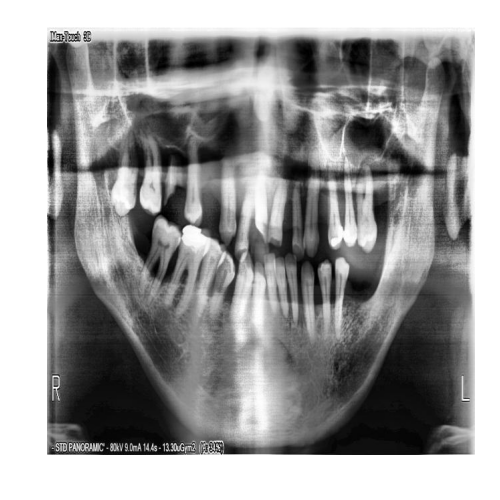

Button(description='save', style=ButtonStyle())

No such comm: 0bb32a281fd940c0bab6b0a47fca7977


In [ ]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(image)


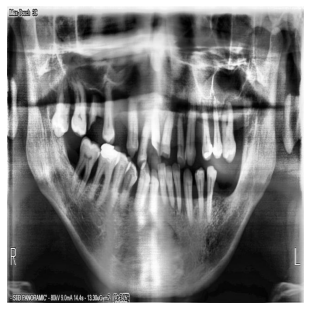

In [146]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

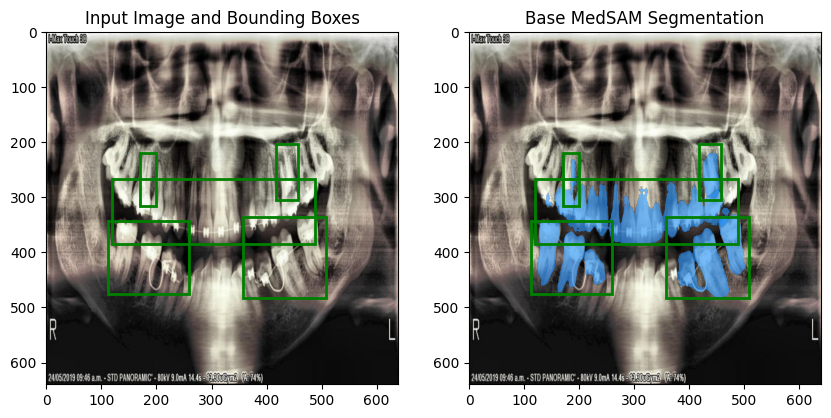

In [92]:
# test_dataset.return_as_tensor = False
# img_np = test_dataset[12]["pixel_values"]
from skimage import transform, io

img_np = io.imread("Datasets/Dental project.v19i.coco-1/test/InShot_20240419_215338310_jpg.rf.5a5068b0f66fa8d7290fb80fef362e7d.jpg")

if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

# Resize image to 1024x1024
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)

# Normalize image to [0, 1] range
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)

# Convert image to tensor (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to("cuda")

# Retrieve all bounding boxes for index 0
box_np = np.array(test_dataset.get_object_bounding_boxes(0))  # Shape (5, 4)

# Compute image embedding **once**
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)

# Convert to PyTorch tensor and reshape (B, 1, 4)
box_1024 = torch.tensor(box_np, dtype=torch.float32, device="cuda")  # (5, 4)
box_1024 = (box_1024 / torch.tensor([W, H, W, H], device="cuda")) * 1024  # Scale to 1024x1024
box_1024 = box_1024[:, None, :]  # (5, 1, 4)

# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = medsam_inference(medsam_model, image_embedding, box_1024, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image with bounding boxes
ax[0].imshow(img_3c)
for box in box_np:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_3c)
for box, mask in zip(box_np, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1])
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

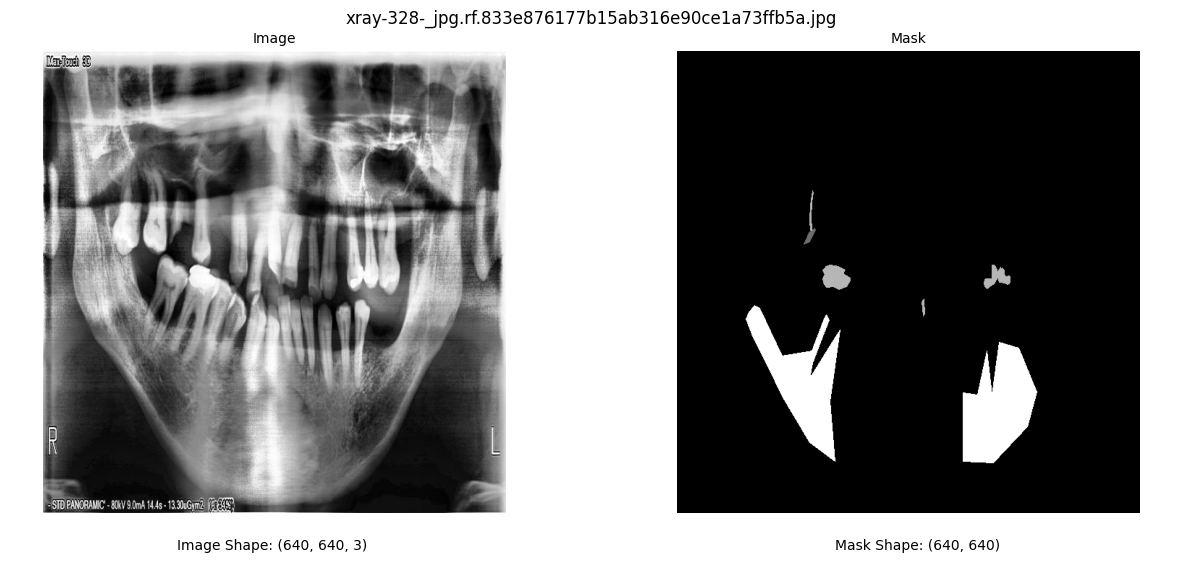

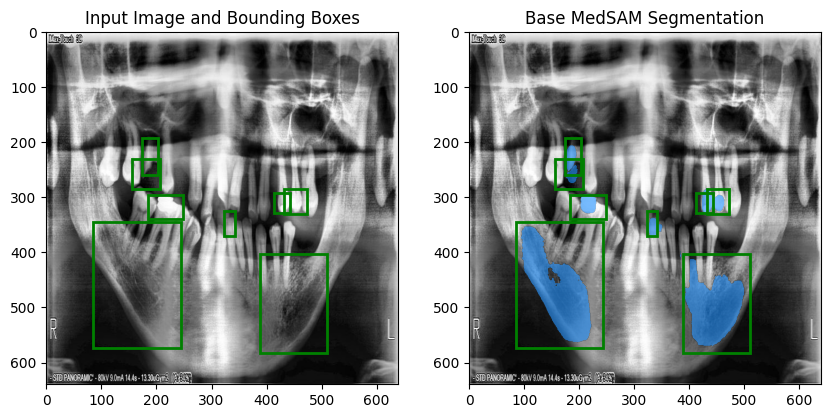

In [184]:


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape


# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = medsam_inference(medsam_model, image_embedding, box_1024, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))



# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1])
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

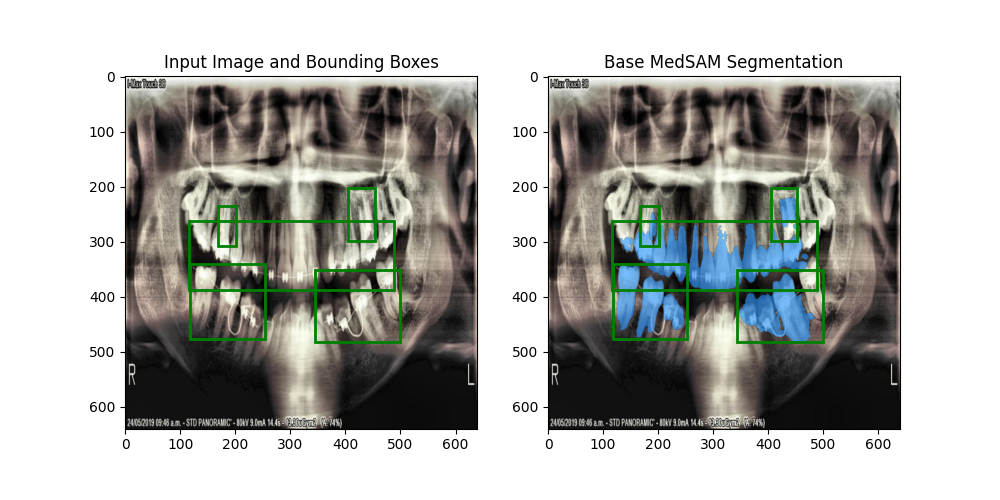

In [ ]:


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

# Get tensors
img_np, box_np, gt_masks = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape




# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)

# Convert to PyTorch tensor and reshape (B, 1, 4)
box_1024 = torch.tensor(box_np, dtype=torch.float32, device="cuda")  # (5, 4)
box_1024 = (box_1024 / torch.tensor([W, H, W, H], device="cuda")) * 1024  # Scale to 1024x1024
box_1024 = box_1024[:, None, :]  # (5, 1, 4)

# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = medsam_inference(medsam_model, image_embedding, box_1024, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))








# Original image with bounding boxes
ax[0].imshow(img_original)
for box in box_np:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(box_np, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1])
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

In [ ]:
  # Preprocess and return tensors for use in fine-tuning MedSAM
        if self._return_as_medsam:

            # Resize image to 1024x1024 for MedSAM
            image_resized = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)

            # Normalize image to [0, 1] range
            image_resized = image_resized.astype(np.float32) / 255.0  # Normalize to [0,1]

            # Convert image to tensor (3, H, W)
            image_tensor = torch.tensor(image_resized).float().permute(2, 0, 1).unsqueeze(0).to("cuda")

            # Get object masks using _find_object_masks (each mask for each object)
            object_masks = self._find_object_masks(img_path, os.path.join(os.path.dirname(os.path.dirname(mask_path)), "individual_masks"))

            # Convert each object mask to binary
            binary_object_masks = [((obj_mask > 0).astype(np.float32)) for obj_mask in object_masks]

            # Get bounding boxes (scaled to 1024x1024)
            bounding_boxes = self.get_object_bounding_boxes(idx)
            bounding_boxes = torch.tensor(bounding_boxes, dtype=torch.float32)

            H, W, _ = image.shape
            
            # Convert to PyTorch tensor and reshape (B, 1, 4)
            box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cuda")  # (5, 4)
            box_1024 = (box_1024 / torch.tensor([W, H, W, H], device="cuda")) * 1024  # Scale to 1024x1024
            box_1024 = box_1024[:, None, :]  # (5, 1, 4)



            # Return the preprocessed data for MedSAM
            return {
                "pixel_values": image_tensor,  # (3, 1024, 1024)
                "input_boxes": bounding_boxes,  # List of bounding boxes
                "ground_truth_masks": [torch.tensor(obj_mask, dtype=torch.float32) for obj_mask in binary_object_masks]  # List of object masks
            }